In [1]:
# Cell 1: Setup and Imports
"""
Research Paper Navigator - RAG POC
===================================
Testing core functionality:
1. PDF ingestion and parsing
2. Chunking strategies (fixed, semantic, recursive)
3. Embedding and vector storage
4. Retrieval (dense, sparse, hybrid)
5. Reranking
6. Generation with context
7. Evaluation metrics
"""

import os
import sys
from pathlib import Path

# Add src to path (for later when we modularize)
project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

# Core imports
import warnings
warnings.filterwarnings('ignore')

from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_ollama import ChatOllama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# BM25 for hybrid search
from rank_bm25 import BM25Okapi

# Utilities
from tqdm.notebook import tqdm
import time
from datetime import datetime

print("✅ All imports successful!")
print(f"Project root: {project_root}")

✅ All imports successful!
Project root: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag


In [2]:
# Cell 2: Configuration
"""
Configuration for the RAG system
"""

class Config:
    # Paths
    DATA_DIR = project_root / "data"
    RAW_DIR = DATA_DIR / "raw"
    PROCESSED_DIR = DATA_DIR / "processed"
    VECTOR_STORE_DIR = DATA_DIR / "vector_store"
    
    # Ensure directories exist
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    VECTOR_STORE_DIR.mkdir(parents=True, exist_ok=True)
    
    # Model configurations
    EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # Fast, 384 dims
    # Alternative: "BAAI/bge-large-en-v1.5"  # Better quality, 1024 dims
    
    LLM_MODEL = "llama3.1:8b"
    LLM_TEMPERATURE = 0.1  # Lower for factual responses
    
    # Chunking configurations
    CHUNK_SIZE = 512
    CHUNK_OVERLAP = 128
    
    # Retrieval configurations
    TOP_K = 5  # Number of chunks to retrieve
    RERANK_TOP_K = 3  # After reranking
    
    # Collection name for ChromaDB
    COLLECTION_NAME = "research_papers"

config = Config()

print("📁 Data directories:")
print(f"  Raw PDFs: {config.RAW_DIR}")
print(f"  Processed: {config.PROCESSED_DIR}")
print(f"  Vector Store: {config.VECTOR_STORE_DIR}")

📁 Data directories:
  Raw PDFs: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/raw
  Processed: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/processed
  Vector Store: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/vector_store


In [3]:
# Cell 3: Helper Functions for PDF Parsing
"""
Different PDF parsing strategies to compare
"""

def load_pdf_pypdf(pdf_path: str) -> List[Dict]:
    """Basic PDF loading with PyPDF"""
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    return documents

def load_pdf_pymupdf(pdf_path: str) -> List[Dict]:
    """Better quality PDF loading with PyMuPDF"""
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()
    return documents

def extract_metadata(document) -> Dict:
    """Extract useful metadata from document"""
    metadata = document.metadata.copy()
    
    # Add extraction timestamp
    metadata['extracted_at'] = datetime.now().isoformat()
    
    # Character count
    metadata['char_count'] = len(document.page_content)
    
    return metadata

# Test with a sample PDF (you'll add PDFs to data/raw/)
print("PDF parsing functions ready!")
print("\nTo test, add a PDF to:", config.RAW_DIR)
print("Then run: docs = load_pdf_pymupdf('data/raw/your_paper.pdf')")

PDF parsing functions ready!

To test, add a PDF to: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/raw
Then run: docs = load_pdf_pymupdf('data/raw/your_paper.pdf')


In [4]:
# Cell 4: Chunking Strategies
"""
Compare different chunking strategies
"""

def chunk_fixed_size(documents, chunk_size=512, overlap=128):
    """Fixed-size chunking"""
    text_splitter = CharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separator="\n",
    )
    chunks = text_splitter.split_documents(documents)
    return chunks

def chunk_recursive(documents, chunk_size=512, overlap=128):
    """Recursive chunking - better for preserving context"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", ". ", " ", ""],
    )
    chunks = text_splitter.split_documents(documents)
    return chunks

def analyze_chunks(chunks):
    """Analyze chunk statistics"""
    lengths = [len(chunk.page_content) for chunk in chunks]
    
    stats = {
        'total_chunks': len(chunks),
        'avg_length': np.mean(lengths),
        'std_length': np.std(lengths),
        'min_length': np.min(lengths),
        'max_length': np.max(lengths),
    }
    
    return stats, lengths

def visualize_chunk_distribution(lengths, title="Chunk Length Distribution"):
    """Visualize chunk size distribution"""
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(lengths), color='red', linestyle='--', 
                label=f'Mean: {np.mean(lengths):.0f}')
    plt.xlabel('Chunk Length (characters)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("✅ Chunking functions ready!")

✅ Chunking functions ready!


In [5]:
# Cell 5: Initialize Embeddings and Vector Store
"""
Setup embedding model and vector database
"""

# Initialize embedding model
print("Loading embedding model...")
embeddings = HuggingFaceEmbeddings(
    model_name=config.EMBEDDING_MODEL,
    model_kwargs={'device': 'cpu'},  # Use 'mps' for M4 GPU if supported
    encode_kwargs={'normalize_embeddings': True}
)

print(f"✅ Embedding model loaded: {config.EMBEDDING_MODEL}")
print(f"   Dimension: {len(embeddings.embed_query('test'))}")

def create_vector_store(chunks, collection_name=None):
    """Create ChromaDB vector store from chunks"""
    if collection_name is None:
        collection_name = config.COLLECTION_NAME
    
    print(f"Creating vector store with {len(chunks)} chunks...")
    
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=str(config.VECTOR_STORE_DIR)
    )
    
    print(f"✅ Vector store created: {collection_name}")
    return vectorstore

def load_vector_store(collection_name=None):
    """Load existing vector store"""
    if collection_name is None:
        collection_name = config.COLLECTION_NAME
    
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory=str(config.VECTOR_STORE_DIR)
    )
    
    print(f"✅ Vector store loaded: {collection_name}")
    return vectorstore

Loading embedding model...


/var/folders/9c/3n849rn554l15tgrg12vm59m0000gn/T/ipykernel_58301/402174243.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embedding model loaded: sentence-transformers/all-MiniLM-L6-v2
   Dimension: 384


In [6]:
# Cell 6: Dense Retrieval (Vector Search)
"""
Dense retrieval using embeddings
"""

def dense_retrieval(vectorstore, query: str, k: int = 5):
    """Retrieve using dense embeddings"""
    start_time = time.time()
    
    # Similarity search
    results = vectorstore.similarity_search_with_score(query, k=k)
    
    retrieval_time = time.time() - start_time
    
    # Format results
    formatted_results = []
    for doc, score in results:
        formatted_results.append({
            'content': doc.page_content,
            'metadata': doc.metadata,
            'score': float(score),
            'method': 'dense'
        })
    
    return formatted_results, retrieval_time

print("✅ Dense retrieval ready!")

✅ Dense retrieval ready!


In [7]:
# Cell 7: Sparse Retrieval (BM25)
"""
Sparse retrieval using BM25 for comparison/hybrid
"""

class BM25Retriever:
    def __init__(self, chunks):
        """Initialize BM25 with document chunks"""
        self.chunks = chunks
        
        # Tokenize documents
        self.tokenized_docs = [
            doc.page_content.lower().split() 
            for doc in chunks
        ]
        
        # Create BM25 index
        self.bm25 = BM25Okapi(self.tokenized_docs)
        print(f"✅ BM25 index created with {len(chunks)} documents")
    
    def search(self, query: str, k: int = 5):
        """Search using BM25"""
        start_time = time.time()
        
        # Tokenize query
        tokenized_query = query.lower().split()
        
        # Get scores
        scores = self.bm25.get_scores(tokenized_query)
        
        # Get top-k indices
        top_k_idx = np.argsort(scores)[::-1][:k]
        
        retrieval_time = time.time() - start_time
        
        # Format results
        results = []
        for idx in top_k_idx:
            results.append({
                'content': self.chunks[idx].page_content,
                'metadata': self.chunks[idx].metadata,
                'score': float(scores[idx]),
                'method': 'bm25'
            })
        
        return results, retrieval_time

print("✅ BM25 retriever ready!")

✅ BM25 retriever ready!


In [8]:
# Cell 8: Hybrid Retrieval
"""
Combine dense and sparse retrieval
"""

def hybrid_retrieval(
    vectorstore, 
    bm25_retriever, 
    query: str, 
    k: int = 5,
    alpha: float = 0.5  # Weight for dense vs sparse
):
    """
    Hybrid search combining dense and sparse retrieval
    alpha: weight for dense (1-alpha for sparse)
    """
    # Get results from both methods
    dense_results, _ = dense_retrieval(vectorstore, query, k=k*2)
    sparse_results, _ = bm25_retriever.search(query, k=k*2)
    
    # Normalize scores to [0, 1]
    def normalize_scores(results):
        scores = [r['score'] for r in results]
        if max(scores) == min(scores):
            return results
        
        normalized = []
        for r in results:
            norm_score = (r['score'] - min(scores)) / (max(scores) - min(scores))
            r_copy = r.copy()
            r_copy['score'] = norm_score
            normalized.append(r_copy)
        return normalized
    
    dense_results = normalize_scores(dense_results)
    sparse_results = normalize_scores(sparse_results)
    
    # Combine with Reciprocal Rank Fusion (RRF)
    combined_scores = {}
    
    for rank, result in enumerate(dense_results, 1):
        content = result['content']
        combined_scores[content] = alpha / (60 + rank)
    
    for rank, result in enumerate(sparse_results, 1):
        content = result['content']
        if content in combined_scores:
            combined_scores[content] += (1 - alpha) / (60 + rank)
        else:
            combined_scores[content] = (1 - alpha) / (60 + rank)
    
    # Sort by combined score
    sorted_results = sorted(
        combined_scores.items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:k]
    
    # Format results
    hybrid_results = []
    for content, score in sorted_results:
        # Find original result for metadata
        orig = next((r for r in dense_results + sparse_results 
                    if r['content'] == content), None)
        
        hybrid_results.append({
            'content': content,
            'metadata': orig['metadata'] if orig else {},
            'score': score,
            'method': 'hybrid'
        })
    
    return hybrid_results

print("✅ Hybrid retrieval ready!")

✅ Hybrid retrieval ready!


In [9]:
# Cell 9: Initialize LLM
"""
Setup local LLM with Ollama
"""

print("Initializing Ollama LLM...")

llm = ChatOllama(
    model=config.LLM_MODEL,
    temperature=config.LLM_TEMPERATURE,
)

# Test the LLM
test_response = llm.invoke("Say 'LLM is ready!' and nothing else.")
print(f"✅ LLM Response: {test_response.content}")

Initializing Ollama LLM...
✅ LLM Response: LLM is ready!


In [10]:
# Cell 10: RAG Chain with Custom Prompt
"""
Create RAG chain for Q&A
"""

# Custom prompt for research papers
RAG_PROMPT_TEMPLATE = """You are an AI assistant helping researchers understand academic papers.

Use the following pieces of context from research papers to answer the question. 
If you don't know the answer based on the context, say so - don't make up information.

When possible, mention which paper or section the information comes from.

Context:
{context}

Question: {question}

Answer (be concise but comprehensive):"""

RAG_PROMPT = PromptTemplate(
    template=RAG_PROMPT_TEMPLATE,
    input_variables=["context", "question"]
)

def create_rag_chain(vectorstore):
    """Create RAG QA chain"""
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": config.TOP_K}),
        chain_type_kwargs={"prompt": RAG_PROMPT},
        return_source_documents=True
    )
    
    return qa_chain

def query_rag(qa_chain, question: str):
    """Query the RAG system"""
    start_time = time.time()
    
    result = qa_chain.invoke({"query": question})
    
    query_time = time.time() - start_time
    
    return {
        'question': question,
        'answer': result['result'],
        'source_documents': result['source_documents'],
        'query_time': query_time
    }

print("✅ RAG chain functions ready!")

✅ RAG chain functions ready!


In [11]:
# Cell 11: Evaluation Metrics
"""
Simple evaluation metrics for RAG quality
"""

def calculate_faithfulness(answer: str, context_docs: List) -> Dict:
    """
    Simple faithfulness check - are claims in answer supported by context?
    (In production, you'd use an LLM-as-judge for this)
    """
    context_text = " ".join([doc.page_content for doc in context_docs])
    
    # Simple heuristic: check if answer phrases appear in context
    answer_sentences = answer.split('. ')
    
    supported_count = 0
    for sentence in answer_sentences:
        # Check if key phrases from sentence appear in context
        words = sentence.lower().split()
        # Consider 3-word phrases
        for i in range(len(words) - 2):
            phrase = ' '.join(words[i:i+3])
            if phrase in context_text.lower():
                supported_count += 1
                break
    
    faithfulness_score = supported_count / len(answer_sentences) if answer_sentences else 0
    
    return {
        'faithfulness_score': faithfulness_score,
        'total_sentences': len(answer_sentences),
        'supported_sentences': supported_count
    }

def evaluate_retrieval(query: str, retrieved_docs: List, relevant_doc_ids: List = None):
    """
    Evaluate retrieval quality
    (In real scenario, you'd have ground truth relevant docs)
    """
    # For now, just analyze retrieved docs
    stats = {
        'num_retrieved': len(retrieved_docs),
        'avg_doc_length': np.mean([len(doc.page_content) for doc in retrieved_docs]),
        'unique_sources': len(set([doc.metadata.get('source', 'unknown') 
                                   for doc in retrieved_docs]))
    }
    
    return stats

print("✅ Evaluation functions ready!")

✅ Evaluation functions ready!


In [12]:
# Cell 13: Sample Test Data Generator
"""
Helper to download sample research papers for testing
"""

import urllib.request

def download_sample_papers():
    """
    Download sample papers from ArXiv
    """
    sample_papers = {
        'attention_is_all_you_need.pdf': 
            'https://arxiv.org/pdf/1706.03762.pdf',  # Transformer paper
        'bert.pdf': 
            'https://arxiv.org/pdf/1810.04805.pdf',  # BERT paper
    }
    
    print("Downloading sample papers...")
    for filename, url in sample_papers.items():
        filepath = config.RAW_DIR / filename
        if not filepath.exists():
            print(f"  Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
            print(f"  ✅ Saved to {filepath}")
        else:
            print(f"  ⏭️  {filename} already exists")
    
    print("\n✅ Sample papers ready!")
    return list(sample_papers.keys())

# Uncomment to download
downloaded_files = download_sample_papers()

  ✅ Saved to /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/raw/attention_is_all_you_need.pdf
  ✅ Saved to /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/raw/bert.pdf

✅ Sample papers ready!


In [13]:
# Cell 12: Complete RAG Testing Pipeline
"""
End-to-end testing workflow
"""

def test_rag_pipeline(pdf_path: str, test_queries: List[str]):
    """
    Complete RAG pipeline test
    """
    results = {
        'pdf_path': pdf_path,
        'timestamp': datetime.now().isoformat(),
        'queries': []
    }
    
    print("=" * 70)
    print("RAG PIPELINE TEST")
    print("=" * 70)
    
    # Step 1: Load PDF
    print("\n📄 Step 1: Loading PDF...")
    documents = load_pdf_pymupdf(pdf_path)
    print(f"   Loaded {len(documents)} pages")
    
    # Step 2: Chunk documents
    print("\n✂️  Step 2: Chunking documents...")
    chunks = chunk_recursive(documents)
    stats, lengths = analyze_chunks(chunks)
    print(f"   Created {stats['total_chunks']} chunks")
    print(f"   Avg length: {stats['avg_length']:.0f} chars")
    
    visualize_chunk_distribution(lengths)
    
    # Step 3: Create vector store
    print("\n🔍 Step 3: Creating vector store...")
    vectorstore = create_vector_store(chunks)
    
    # Step 4: Initialize BM25
    print("\n📊 Step 4: Initializing BM25...")
    bm25_retriever = BM25Retriever(chunks)
    
    # Step 5: Create RAG chain
    print("\n⚙️  Step 5: Creating RAG chain...")
    qa_chain = create_rag_chain(vectorstore)
    
    # Step 6: Test queries
    print("\n" + "=" * 70)
    print("TESTING QUERIES")
    print("=" * 70)
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n🔎 Query {i}: {query}")
        print("-" * 70)
        
        # Get answer
        result = query_rag(qa_chain, query)
        
        print(f"\n💡 Answer:\n{result['answer']}")
        print(f"\n⏱️  Time: {result['query_time']:.2f}s")
        
        # Evaluate
        faithfulness = calculate_faithfulness(
            result['answer'], 
            result['source_documents']
        )
        print(f"\n📈 Faithfulness: {faithfulness['faithfulness_score']:.2f}")
        
        print(f"\n📚 Sources ({len(result['source_documents'])}):")
        for j, doc in enumerate(result['source_documents'], 1):
            preview = doc.page_content[:100] + "..."
            print(f"   {j}. {preview}")
        
        results['queries'].append({
            'query': query,
            'answer': result['answer'],
            'time': result['query_time'],
            'faithfulness': faithfulness['faithfulness_score'],
            'num_sources': len(result['source_documents'])
        })
        
        print("\n" + "=" * 70)
    
    return results

print("✅ Complete testing pipeline ready!")
print("\n📝 Usage:")
print("results = test_rag_pipeline(")
print("    pdf_path='data/raw/your_paper.pdf',")
print("    test_queries=[")
print("        'What is the main contribution of this paper?',")
print("        'What datasets were used?',")
print("        'What are the key findings?'")
print("    ]")
print(")")

✅ Complete testing pipeline ready!

📝 Usage:
results = test_rag_pipeline(
    pdf_path='data/raw/your_paper.pdf',
    test_queries=[
        'What is the main contribution of this paper?',
        'What datasets were used?',
        'What are the key findings?'
    ]
)


RAG PIPELINE TEST

📄 Step 1: Loading PDF...
   Loaded 16 pages

✂️  Step 2: Chunking documents...
   Created 169 chunks
   Avg length: 472 chars


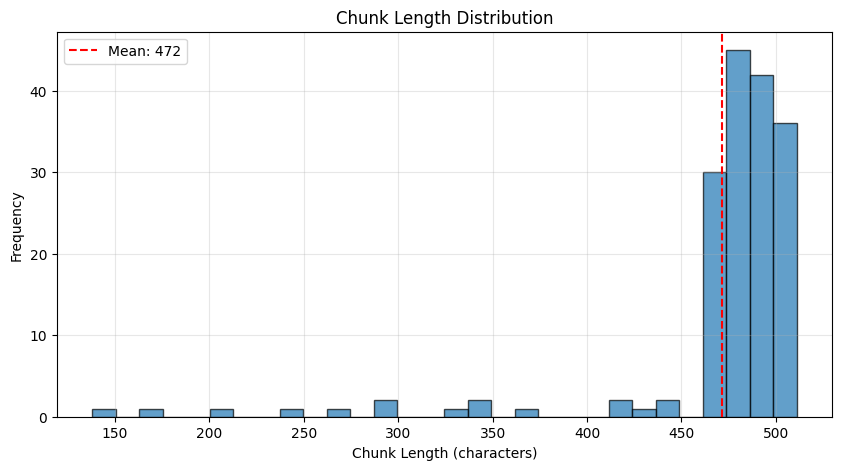


🔍 Step 3: Creating vector store...
Creating vector store with 169 chunks...


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


✅ Vector store created: research_papers

📊 Step 4: Initializing BM25...
✅ BM25 index created with 169 documents

⚙️  Step 5: Creating RAG chain...

TESTING QUERIES

🔎 Query 1: What is the main contribution of this paper?
----------------------------------------------------------------------

💡 Answer:
Unfortunately, I don't have enough information to determine which specific paper you are referring to. The context provided includes multiple papers and sections, but it's not clear which one you're asking about.

Could you please specify which paper or section you'd like me to focus on? For example, is it the QANet paper (Rowan Zellers et al., 2018), the SWAG paper (Ronan Collobert and Jason Weston, 2008), or another one?

Once I know which paper you're interested in, I'll do my best to summarize its main contribution.

⏱️  Time: 13.94s

📈 Faithfulness: 0.50

📚 Sources (5):
   1. neural networks? In Advances in neural information
processing systems, pages 3320–3328.
Adams Wei Yu...
   2.

In [16]:
results = test_rag_pipeline(
    pdf_path='../data/raw/bert.pdf',
    test_queries=[
        'What is the main contribution of this paper?',
        'What datasets were used?',
        'What are the key findings?'
    ]
)